Develop a model that can accurately recognize food items from images and estimate their calorie content, enabling users to track their dietary intake and make informed food choices

In [ ]:
# Mounting drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Importing Necessary Libraries
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


ImportError: Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
# Defining paths to ther dataset
train_dir = '/content/drive/MyDrive/Prodigy/train_food'
test_dir = '/content/drive/MyDrive/Prodigy/val_food'

# Defining image data generators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 359 images belonging to 20 classes.
Found 342 images belonging to 20 classes.


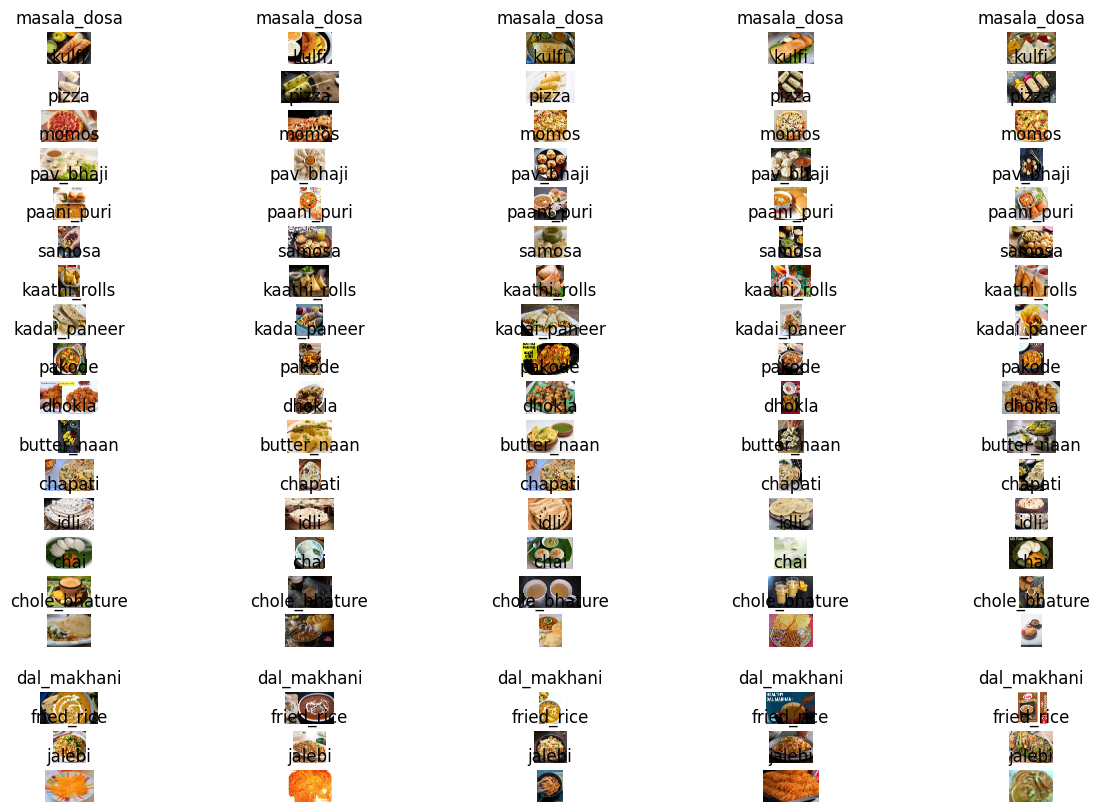

In [ ]:
# Function to display sample images
def display_samples(train_dir, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(train_dir, class_name)
        image_files = os.listdir(class_dir)[:num_samples]
        for j, image_file in enumerate(image_files):
            img = Image.open(os.path.join(class_dir, image_file))
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.show()

class_names = os.listdir(train_dir)
display_samples(train_dir, class_names)



In [ ]:
#Defining the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
#Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20
)


Epoch 1/20
11/11 [==============================] - 421s 40s/step - loss: 3.0542 - accuracy: 0.0428 - val_loss: 2.9815 - val_accuracy: 0.0750
Epoch 2/20
11/11 [==============================] - 40s 4s/step - loss: 2.9680 - accuracy: 0.0597 - val_loss: 2.9500 - val_accuracy: 0.0719
Epoch 3/20
11/11 [==============================] - 47s 4s/step - loss: 2.8354 - accuracy: 0.1223 - val_loss: 2.8398 - val_accuracy: 0.1375
Epoch 4/20
11/11 [==============================] - 37s 3s/step - loss: 2.7058 - accuracy: 0.1651 - val_loss: 2.8555 - val_accuracy: 0.0969
Epoch 5/20
11/11 [==============================] - 46s 4s/step - loss: 2.6443 - accuracy: 0.1193 - val_loss: 2.8475 - val_accuracy: 0.1562
Epoch 6/20
11/11 [==============================] - 38s 3s/step - loss: 2.4974 - accuracy: 0.2045 - val_loss: 2.8462 - val_accuracy: 0.1500
Epoch 7/20
11/11 [==============================] - 45s 4s/step - loss: 2.4600 - accuracy: 0.2131 - val_loss: 2.7648 - val_accuracy: 0.1937
Epoch 8/20
11/11 [

In [ ]:
#Evaluating the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')


11/11 [==============================] - 17s 2s/step - loss: 3.7949 - accuracy: 0.2573
Test accuracy: 25.73%


1/1 [==============================] - 0s 39ms/step
Predicted food item: kulfi, Estimated calories: 200


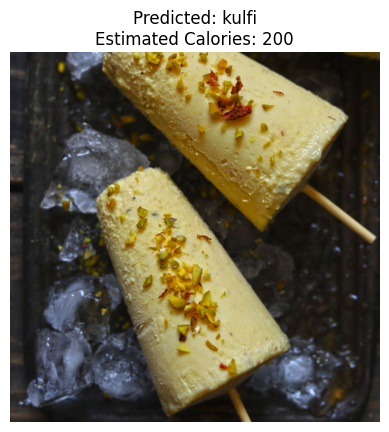

In [ ]:
# Mapping the classes to calorie content
class_to_calories = {
    'butter naan': 240,
    'chai': 120,
    'chapati': 100,
    'chole bhature': 450,
    'dal makhani': 320,
    'dhokla': 150,
    'fried rice': 350,
    'idli': 50,
    'jalebi': 150,
    'kaathi rolls': 300,
    'kadai paneer': 400,
    'kulfi': 200,
    'masala dosa': 300,
    'pizza': 270,
    'pav bhaji': 400,
    'momos': 35,
    'paani puri': 50,
    'pakode': 150,
    'burger': 295,
    'samosa': 260
}

def predict_and_estimate_calories(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    class_label = train_generator.class_indices
    class_label = dict((v,k) for k,v in class_label.items())

    predicted_class_label = class_label[predicted_class[0]]
    estimated_calories = class_to_calories[predicted_class_label]

    return predicted_class_label, estimated_calories

# Single Prediction:
image_path = '/content/drive/MyDrive/Prodigy/train_food/kulfi/011.jpg'
predicted_class_label, estimated_calories = predict_and_estimate_calories(image_path)
print(f'Predicted food item: {predicted_class_label}, Estimated calories: {estimated_calories}')

# Displaying the image and prediction
img = mpimg.imread(image_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}\nEstimated Calories: {estimated_calories}')
plt.axis('off')  # Hide axes
plt.show()
